This is notebook with Convolutional Autoencoder 

In [58]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
import nltk
nltk.download('punkt')
import numpy as np
import pandas as pd

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aishw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [59]:
input_img = Input(shape=(110, 50, 1)) 

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((5, 5), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((1, 1), padding='same')(x)

In [60]:
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((5, 5))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='relu')(x)
x = UpSampling2D((1, 1))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [61]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [62]:
df = pd.read_csv("data_v2_1096.csv", encoding="utf8")
docs = []
#iterate over every row of the dataframe
for index,row in df.iterrows():
  docs.append(row["sent_text"])

fn = 'glove.6B.50d.txt'
f = open(fn, encoding="utf8")
embeddings_index = dict()
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs

x_train = np.zeros((index+1,5500));
sntidx = 0
for sent in docs:
  tok = nltk.word_tokenize(sent.lower())
  asent = np.zeros((110,50))
  wrds = 0
  for token in tok:
    if token in embeddings_index:
      asent[wrds] = embeddings_index[token]
      wrds += 1
      if wrds == 110:
        break
  #print asent
  x_train[sntidx] = asent.flatten()
  sntidx += 1
x_test = x_train[100:200]
print(x_train.shape)
print(x_test.shape)

(1096, 5500)
(100, 5500)


In [63]:
x_train = np.reshape(x_train, (len(x_train), 110, 50, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 110, 50, 1))  
print(x_train.shape)
print(x_test.shape)

(1096, 110, 50, 1)
(100, 110, 50, 1)


In [64]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 1096 samples, validate on 100 samples
Epoch 1/50
1096/1096 [==============================] - 11s 10ms/step - loss: 0.5217 - val_loss: 0.1744
Epoch 2/50
1096/1096 [==============================] - 10s 9ms/step - loss: 0.0904 - val_loss: 0.0094
Epoch 3/50
1096/1096 [==============================] - 10s 9ms/step - loss: -0.0391 - val_loss: -0.1216
Epoch 4/50
1096/1096 [==============================] - 10s 9ms/step - loss: -0.1455 - val_loss: -0.2265
Epoch 5/50
1096/1096 [==============================] - 10s 9ms/step - loss: -0.2405 - val_loss: -0.2767
Epoch 6/50
1096/1096 [==============================] - 10s 9ms/step - loss: -0.2748 - val_loss: -0.3195
Epoch 7/50
1096/1096 [==============================] - 11s 10ms/step - loss: -0.3005 - val_loss: -0.3286
Epoch 8/50
1096/1096 [==============================] - 10s 9ms/step - loss: -0.3075 - val_loss: -0.3328
Epoch 9/50
1096/1096 [==============================] - 10s 9ms/step - loss: -0.3111 - val_loss: -0.3348
Epoch 10/5

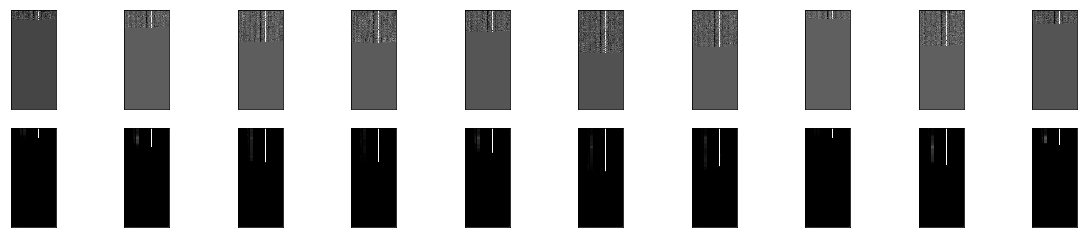

In [65]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n,i+1)
    plt.imshow(x_test[i].reshape(110, 50))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(110, 50))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

ValueError: cannot reshape array of size 440 into shape (4,32)

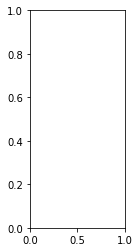

In [68]:
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

application to image denoising

In [69]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 110, 50, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 110, 50, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

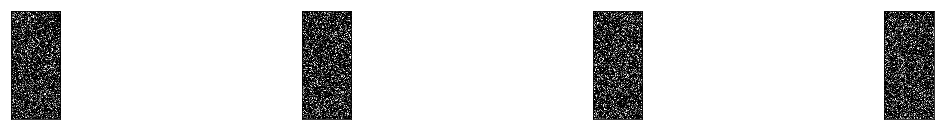

In [71]:
n = 4
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(110, 50))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()